# Support Vector Machines and Kernels

![SVM.png](Assets/SVM.png)

# Learning Objectives

- Apply support vector machines (SVMs)—a popular algorithm used for classification problems
- Recognize SVM similarity to logistic regression
- Compute the cost function of SVMs
- Apply regularization in SVMs and some tips to obtain non-linear classifications with SVMs
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code PRIOR to importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [1]:
from __future__ import print_function
import os
data_path = [ 'data']

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Question 1

* Import the data.
* Create the target variable `y` as a 1/0 column where 1 means red.
* Create a `pairplot` for the dataset.
* Create a bar plot showing the correlations between each column and `y`
* Pick the most 2 correlated fields (using the absolute value of correlations) and create `X`
* Use MinMaxScaler to scale `X`. Note that this will output a np.array. Make it a DataFrame again and rename the columns appropriately.

In [2]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [3]:
y = (data['color'] == 'red').astype(int)
fields = list(data.columns[:-1])  # everything except "color"
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations

total_sulfur_dioxide   -0.700357
free_sulfur_dioxide    -0.471644
residual_sugar         -0.348821
citric_acid            -0.187397
quality                -0.119323
alcohol                -0.032970
pH                      0.329129
density                 0.390645
fixed_acidity           0.486740
sulphates               0.487218
chlorides               0.512678
volatile_acidity        0.653036
dtype: float64

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

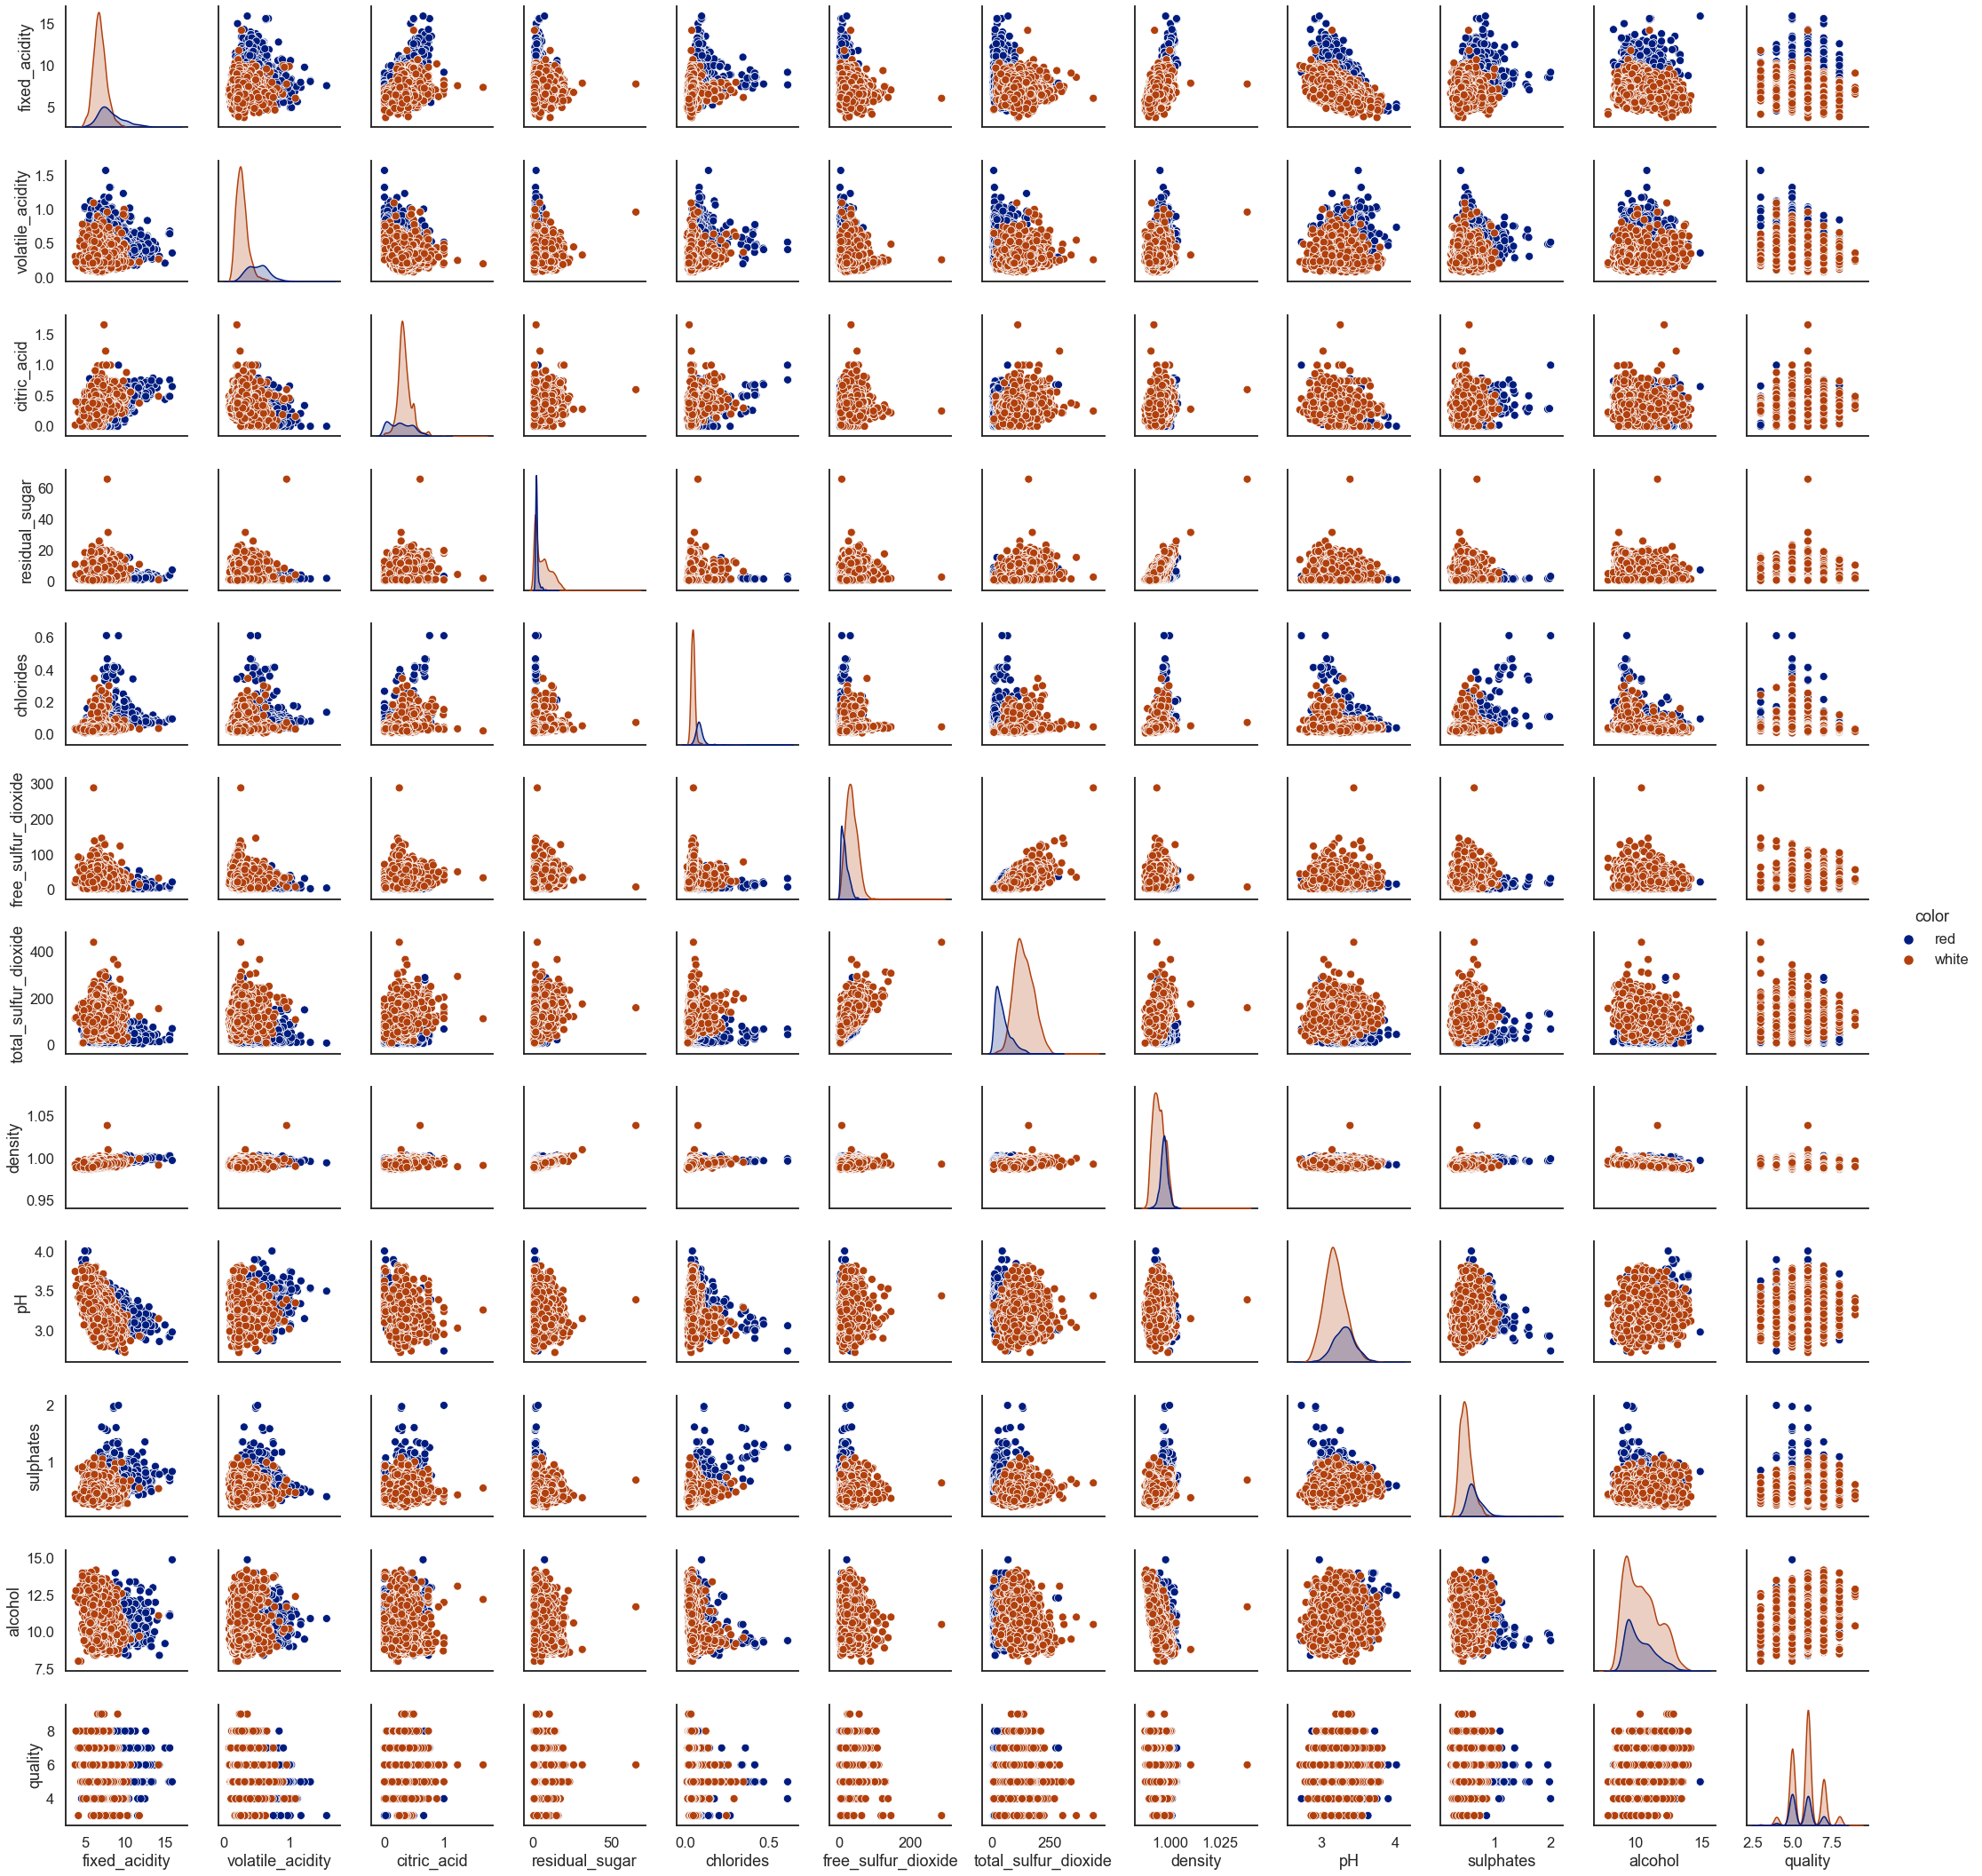

In [5]:
sns.pairplot(data, hue='color')

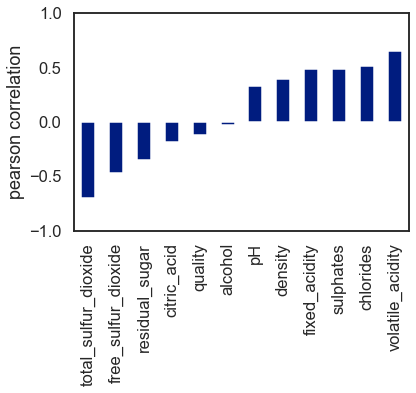

In [6]:
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation');

In [7]:
fields = correlations.map(abs).sort_values().iloc[-2:].index
print(fields)
X = data[fields]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
print(X.columns)

Index(['volatile_acidity', 'total_sulfur_dioxide'], dtype='object')
Index(['volatile_acidity_scaled', 'total_sulfur_dioxide_scaled'], dtype='object')


## Question 2

The goal for this question is to look at the decision boundary of a LinearSVC classifier on this dataset. Check out [this example](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py) in sklearn's documentation. 

* Fit a Linear Support Vector Machine Classifier to `X`, `y`.
* Pick 300 samples from `X`. Get the corresponding `y` value. Store them in variables `X_color` and `y_color`. This is because original dataset is too large and it produces a crowded plot.
* Modify `y_color` so that it has the value "red" instead of 1 and 'yellow' instead of 0.
* Scatter plot X_color's columns. Use the keyword argument "color=y_color" to color code samples.
* Use the code snippet below to plot the decision surface in a color coded way.

```python
x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
xx, yy = np.meshgrid(x_axis, y_axis)
xx_ravel = xx.ravel()
yy_ravel = yy.ravel()
X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
y_grid_predictions = *[YOUR MODEL]*.predict(X_grid)
y_grid_predictions = y_grid_predictions.reshape(xx.shape)
ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
```

Feel free to experiment with different parameter choices for LinearSVC and see the decision boundary.

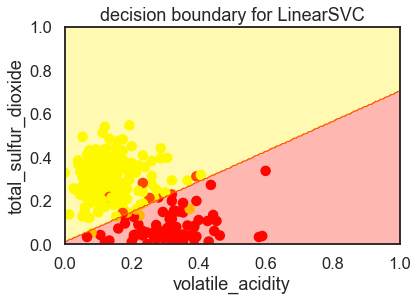

In [8]:
LSVC = LinearSVC()
LSVC.fit(X, y)

X_color = X.sample(300, random_state=45)
y_color = y.loc[X_color.index]
y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
ax = plt.axes()
ax.scatter(
    X_color.iloc[:, 0], X_color.iloc[:, 1],
    color=y_color, alpha=1)
# -----------
x_axis, y_axis = np.arange(0, 1.005, .005), np.arange(0, 1.005, .005)
xx, yy = np.meshgrid(x_axis, y_axis)
xx_ravel = xx.ravel()
yy_ravel = yy.ravel()
X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
y_grid_predictions = LSVC.predict(X_grid)
y_grid_predictions = y_grid_predictions.reshape(xx.shape)
ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
# -----------
ax.set(
    xlabel=fields[0],
    ylabel=fields[1],
    xlim=[0, 1],
    ylim=[0, 1],
    title='decision boundary for LinearSVC');

## Question 3

Let's now fit a Gaussian kernel SVC and see how the decision boundary changes.

* Consolidate the code snippets in Question 2 into one function which takes in an estimator, `X` and `y`, and produces the final plot with decision boundary. The steps are:
    <ol>
     <li> fit model
     <li> get sample 300 records from X and the corresponding y's
     <li> create grid, predict, plot using ax.contourf
     <li> add on the scatter plot
    </ol>
* After copying and pasting code, make sure the finished function uses your input `estimator` and not the LinearSVC model you built.
* For the following values of `gamma`, create a Gaussian Kernel SVC and plot the decision boundary.  
`gammas = [.5, 1, 2, 10]`
* Holding `gamma` constant, for various values of `C`, plot the decision boundary. You may try  
`Cs = [.1, 1, 10]`

In [9]:
def plot_decision_boundary(estimator, X, y):
    estimator.fit(X, y)
    X_color = X.sample(300)
    y_color = y.loc[X_color.index]
    y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
    x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
    xx, yy = np.meshgrid(x_axis, y_axis)
    xx_ravel = xx.ravel()
    yy_ravel = yy.ravel()
    X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
    y_grid_predictions = estimator.predict(X_grid)
    y_grid_predictions = y_grid_predictions.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
    ax.scatter(X_color.iloc[:, 0], X_color.iloc[:, 1], color=y_color, alpha=1)
    ax.set(
        xlabel=fields[0],
        ylabel=fields[1],
        title=str(estimator))

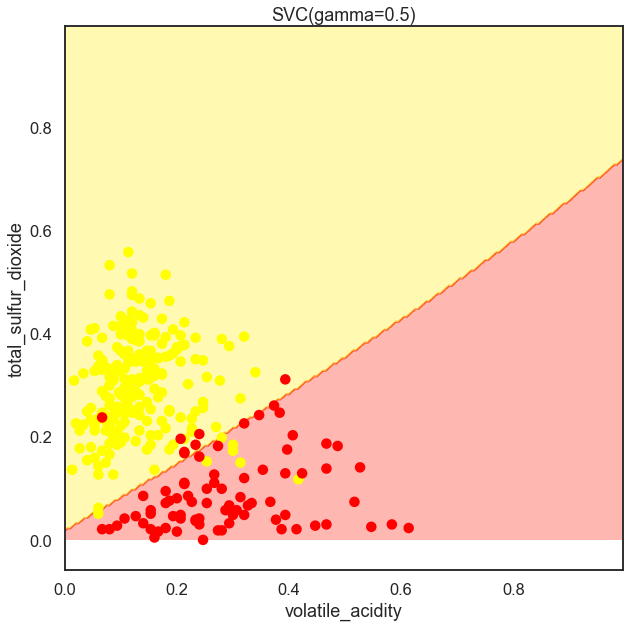

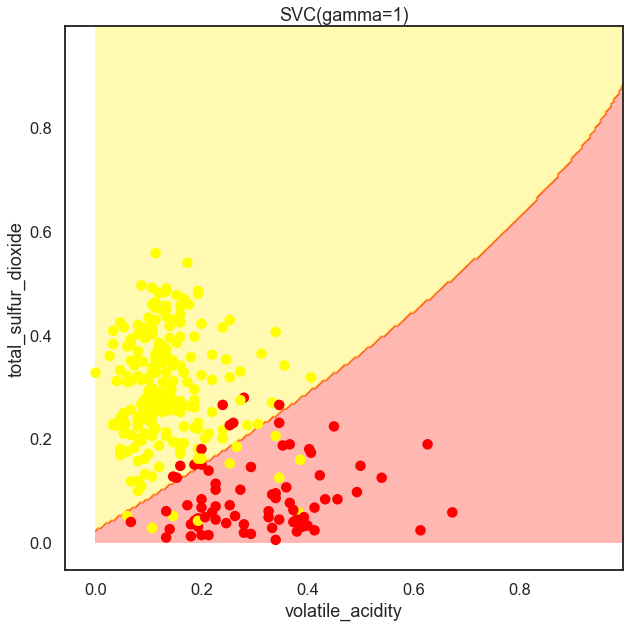

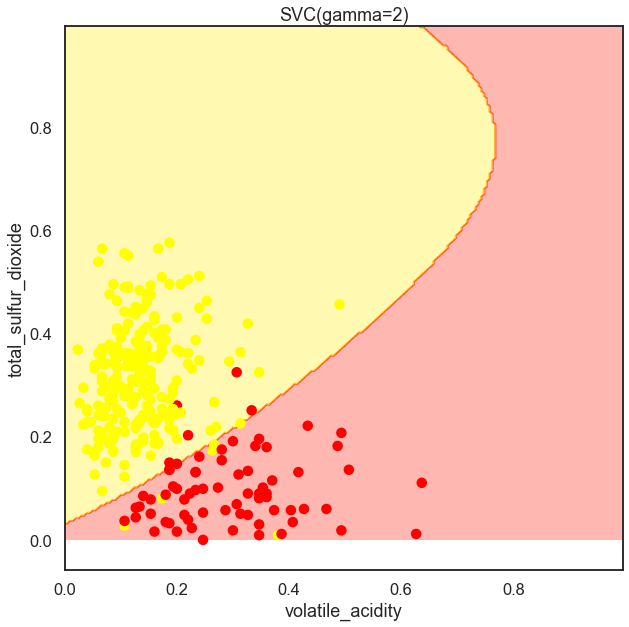

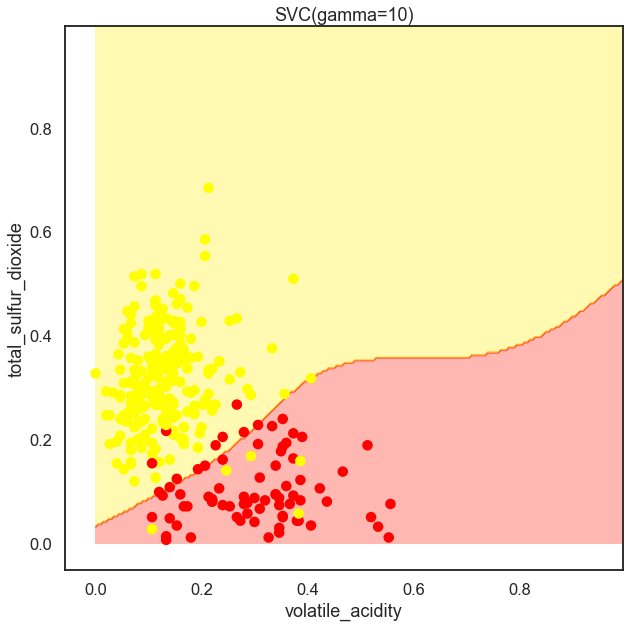

In [10]:
gammas = [.5, 1, 2, 10]
for gamma in gammas:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma)
    plot_decision_boundary(SVC_Gaussian, X, y)

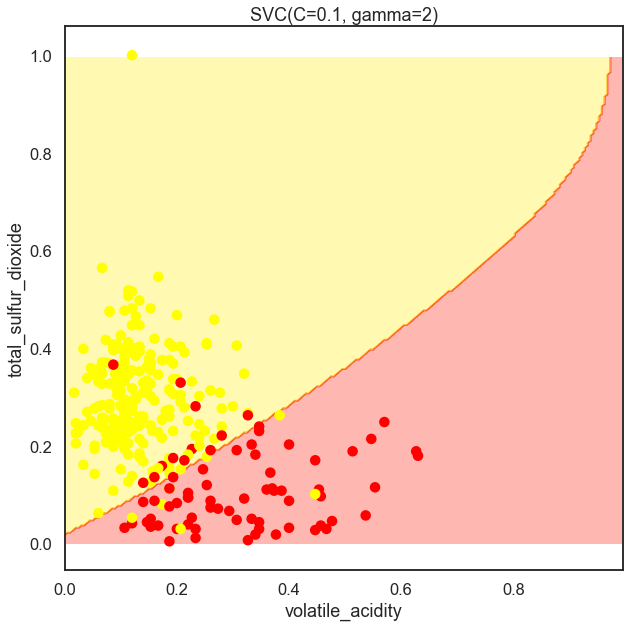

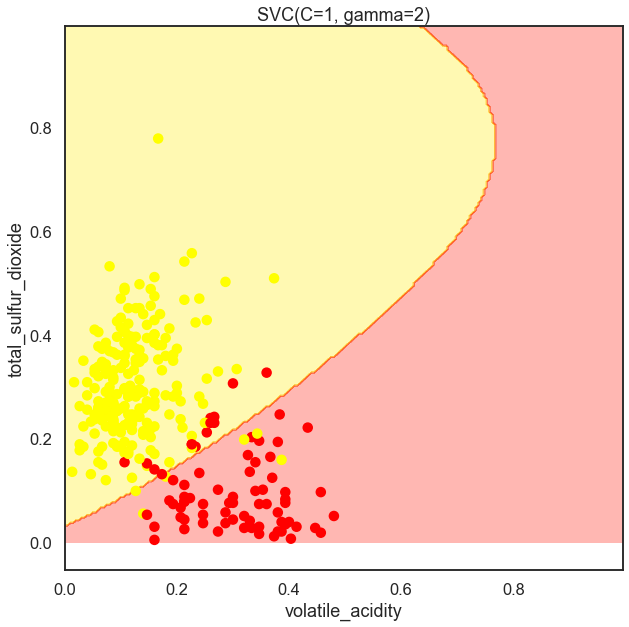

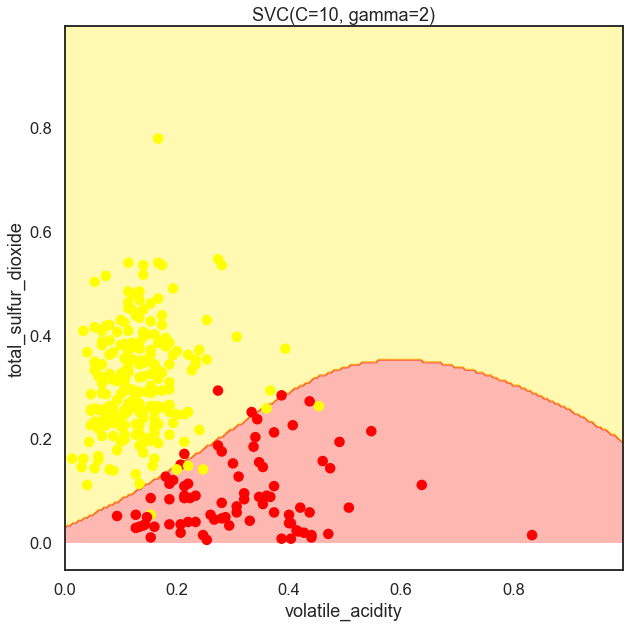

In [11]:
Cs = [.1, 1, 10]
for C in Cs:
    SVC_Gaussian = SVC(kernel='rbf', gamma=2, C=C)
    plot_decision_boundary(SVC_Gaussian, X, y)

## Question 4

In this question, we will compare the fitting times between SVC vs Nystroem with rbf kernel.  
<br><br>
Jupyter Notebooks provide a useful magic function **`%timeit`** which executes a line and prints out the time it took to fit. If you type **`%%timeit`** in the beginning of the cell, then it will run the whole cell and output the running time.

* Re-load the wine quality data if you made changes to the original.
* Create `y` from data.color, and `X` from the rest of the columns.
* Use `%%timeit` to get the time for fitting an SVC with rbf kernel.
* Use `%%timeit` to get the time for the following: fit_transform the data with Nystroem and then fit a SGDClassifier.

Nystroem+SGD will take much shorter to fit. This difference will be more pronounced if the dataset was bigger.

* Make 5 copies of X and concatenate them
* Make 5 copies of y and concatenate them
* Compare the time it takes to fit the both methods above

In [12]:
y = data.color == 'red'
X = data[data.columns[:-1]]

kwargs = {'kernel': 'rbf'}
svc = SVC(**kwargs)
nystroem = Nystroem(**kwargs)
sgd = SGDClassifier()

In [13]:
%%timeit
svc.fit(X, y)

435 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
X_transformed = nystroem.fit_transform(X)
sgd.fit(X_transformed, y)

75.8 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
X2 = pd.concat([X]*5)
y2 = pd.concat([y]*5)

print(X2.shape)
print(y2.shape)

(32485, 12)
(32485,)


In [16]:
%timeit svc.fit(X2, y2)

10.8 s ± 797 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
X2_transformed = nystroem.fit_transform(X2)
sgd.fit(X2_transformed, y2)

313 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
